In [1]:
# -*- coding: utf-8 -*-
"""
Script to invert Tongariro SP data using divergence of streaming current density, q.

from Soegi Kang, Dominique Fournier, UBC, Craig Miller, GNS

https://github.com/simpeg

please use the SP_spherical branch

"""
from SimPEG import Utils, Maps, Mesh
from SimPEG.EM.Static import SP
import matplotlib.pyplot as plt
import numpy as np
from SimPEG.EM.Static.Utils import StaticUtils
import os
from sklearn.metrics import mean_squared_error as mse
from matplotlib.ticker import AutoMinorLocator
import colorcet as cc
from SimPEG.Utils import download
import tarfile

tar_folder = download( "https://storage.googleapis.com/simpeg/miller_et_al_2018.tar.gz")  
tar = tarfile.open(tar_folder, "r:*")
tar.extractall()
tar.close()

datadir ="./"

plt.close('all')


file already exists, new file is called D:\Dropbox\phd\Writing\SP_paper\Scripts\google_drive_binder\miller_et_al_2018.tar.gz
   saved to: D:\Dropbox\phd\Writing\SP_paper\Scripts\google_drive_binder\miller_et_al_2018.tar.gz
Download completed!


In [10]:
# load files

topo = np.loadtxt('topoxyz.dat', skiprows=1)
data = np.loadtxt('Tongariro_SP_data.dat')

cond_model_file = 'MT_model_for_SP_inv.con'
mesh_file = 'Tongariro_SP.msh'


In [11]:
dataInv=data
topo = topo[(topo[:,0] < 1833000) & (topo[:,0] > 1824000)]
topo = topo[(topo[:,1] > 5662000) & (topo[:,1] < 5670000)]
topoInv = topo


In [12]:
#set up the mesh
mesh = Mesh.TensorMesh.readUBC(mesh_file)

print( mesh)
print( 'width in X direction', mesh.hx.sum(), 'm')
print( 'width in Y direction', mesh.hy.sum(), 'm')
print( 'width in Z direction', mesh.hz.sum(), 'm')
print( 'number of cells', mesh.nC)

xref, yref = 1830000, 5666000


  ---- 3-D TensorMesh ----  
   x0: 1824200.00
   y0: 5662200.00
   z0: -850.13
  nCx: 77
  nCy: 68
  nCz: 86
   hx: 207.00,  173.00,  144.00,  120.00,  70*100.00,  120.00,  144.00,  173.00,
   hy: 207.00,  173.00,  144.00,  120.00,  60*100.00,  130.00,  144.00,  173.00,  207.00,
   hz: 344.65,  265.11,  203.93,  156.87,  120.67,  92.82,  71.40,  54.92,  42.25,  32.50,  60*25.00,  16*20.00,
width in X direction 8081.0 m
width in Y direction 7298.0 m
width in Z direction 3205.133662 m
number of cells 450296


In [13]:
#sigma is background conductivity (S/m)

#read in model file
resistivity = mesh.readModelUBC(cond_model_file) #read background conductivity model from file
sigma = 1/resistivity #change to S/m from ohmm
actind = sigma != 1e-8
#sigma = np.ones(mesh.nC)*1e-3 # sets uniform background
sigma[~actind] = 1e-8 #sigma of cells above topo = 1e-8


In [14]:
#set active cells
actMap = Maps.InjectActiveCells(mesh, actind, -100.) #makes cell below topo active and sets cells above topo to 0
mesh2D, topoCC = StaticUtils.gettopoCC(mesh, actind) #~actind = opposite of actind, ie swaps True for False


In [15]:
#drape points onto topo
xyzlocInv = StaticUtils.drapeTopotoLoc(mesh, dataInv[:,:2], actind=actind) #drape data onto topo.
xyzlocInv = np.c_[xyzlocInv[:,:2], xyzlocInv[:,2]]


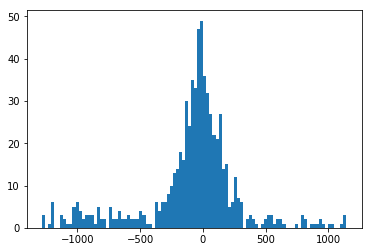

In [16]:
#  Inversion runs in the next sections.
# Setup the problem

from pymatsolver import PardisoSolver

ind = np.argmin(abs(xyzlocInv[:, 0]-xref)+abs(xyzlocInv[:, 1]-yref))
inds = np.ones(xyzlocInv.shape[0], dtype='bool')
inds[ind] = False
xyzM = xyzlocInv[inds, :]
xyzN = np.atleast_2d(xyzlocInv[ind]).repeat(xyzM.shape[0], axis=0)
#wires = Maps.Wires(('jsx', actMap.nP), ('jsy', actMap.nP), ('jsz', actMap.nP))
prob = SP.Problem_CC_Jstore(mesh, sigma=sigma, qMap=actMap, Solver=PardisoSolver)
rx = SP.Rx.Dipole(xyzM, xyzN)
src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh.nC), mesh=mesh, modelType="CurrentSource")
survey = SP.SurveySP_store([src])
survey.pair(prob)

survey.dobs = (dataInv[1:,2]-dataInv[0,2])  # mV


plt.hist(survey.dobs, bins=100)
plt.show()


In [17]:
from SimPEG import (Mesh, Maps, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)

survey.std = 30 #survey std dev in mV
survey.eps = 60 # survey noise floor in mV


dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(nP = actMap.nP)
reg = Regularization.Sparse(mesh, mapping=regmap, indActive=actind)

reg.alpha_s = 1

reg.norms = [0, 1, 1, 1]

opt = Optimization.ProjectedGNCG(maxIter=100, maxIterCG=10, tolX=1e-20, tolF=1e-20)

opt.maxIterLS = 20

invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
target = Directives.TargetMisfit()

# Create an inversion object
update_Jacobi = Directives.UpdatePreconditioner()
update_SensWeight = Directives.UpdateSensitivityWeights()

IRLS = Directives.Update_IRLS(
        f_min_change=1e-3, minGNiter=2, maxIRLSiter = 10,
        coolingFactor=8, coolingRate=3
        )


betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
updateprecond = Directives.UpdatePreconditioner()

#LP only
inv = Inversion.BaseInversion(invProb, directiveList=[betaest, IRLS, updateprecond, update_SensWeight])

#save iterations
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

#creates an initial starting model m0
m0 = np.ones(actMap.nP)*0.
reg.mref = m0



In [18]:
#run the inversion
mopt_Lp = inv.run(m0)
Lp_amp = actMap*mopt_Lp

#recall a particular iteration, comment out if not needed.
xc = opt.recall('xc')
mopt_Lp = xc[8]
Lp_amp = actMap*mopt_Lp



    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.14e+08  5.20e+03  0.00e+00  5.20e+03    3.70e+06      0              
   1  1.14e+08  8.39e+02  1.67e-06  1.03e+03    2.54e+05      0              
   2  1.14e+08  5.72e+02  1.97e-06  7.96e+02    1.26e+05      0   Skip BFGS  
   3  1.43e+07  5.45e+02  1.96e-06  5.73e+02    1.09e+05      0              
   4  1.43e+07  3.71e+02  5.28e-06  4.46e+02    1.55e+05      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p caluclate5.321906045385172e-05
L[p qx qy qz]-norm : [0 1 1 1]
eps_p: 5.321906045385172e-05 eps_q: 1.5958353334148288e-

In [19]:
#save models and calc data

mesh.writeModelUBC('Tongairo_C_Lp_amp.mod', Lp_amp)

#Write calculated data (Lp model)
Lp_calculated = survey.dpred(mopt_Lp)
np.savetxt('Lp_calculated_data.dat', Lp_calculated, fmt='%.4f')


RMS = np.sqrt(mse(Lp_calculated, survey.dobs))
print('RMS = %.3f mV' %RMS)


RMS = 67.401 mV


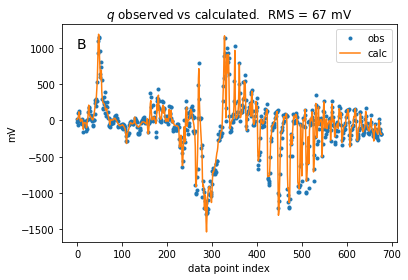

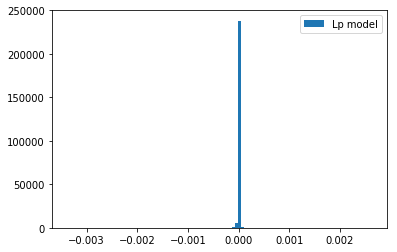

In [26]:
# Plot some L2 model obs and calc
plt.figure()
plt.plot(survey.dobs, '.', label = 'obs')
plt.plot(invProb.dpred, label = 'calc')
plt.legend()
plt.ylabel('mV')
plt.xlabel('data point index')
plt.annotate('B', xy=(0, 1000), fontsize=14)
plt.title('$q$ observed vs calculated.  RMS = %.0f mV' %RMS)
plt.show()

plt.figure()
plt.hist(mopt_Lp, bins=100, label='Lp model')
plt.legend()
plt.show()




In [21]:
# extract core mesh
temp = Lp_amp.copy()
temp[~actind] = np.nan
vmin, vmax = temp[actind].min(), temp[actind].max()

xmin, xmax = dataInv[:,0].min(), dataInv[:,0].max()
ymin, ymax = dataInv[:,1].min(), dataInv[:,1].max()
zmin, zmax = 700, topo[:,2].max()
xyzlim = np.array([[xmin, xmax], [ymin, ymax], [zmin, zmax]])
ind_core, mesh_core = Utils.ExtractCoreMesh(xyzlim, mesh)

ja_est_core = Utils.mkvc(temp[ind_core])
actind_core = actind[ind_core]
jamp_min, jamp_max = ja_est_core[:mesh_core.nC][actind_core].min(), ja_est_core[:mesh_core.nC][actind_core].max()
jamp_lp_core = temp[ind_core]
jamp_lp_core[~actind_core] = np.nan


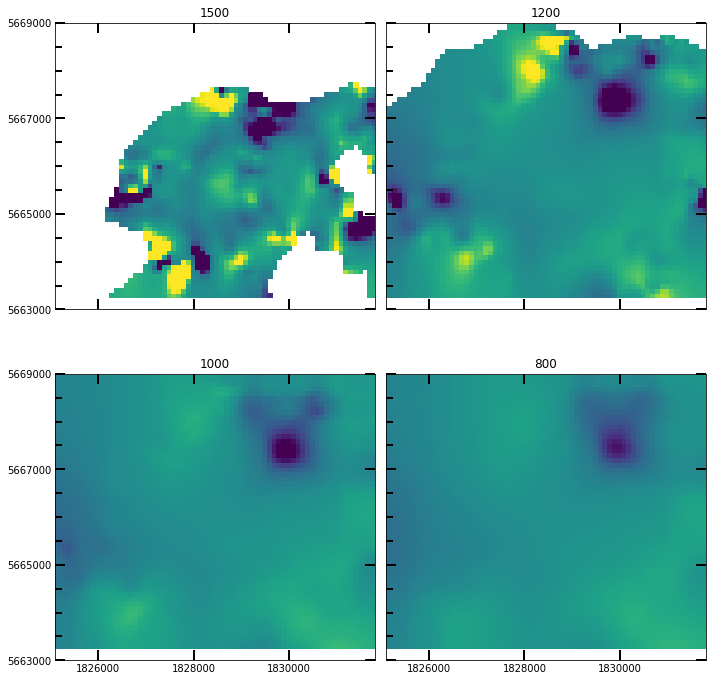

In [22]:
# plot map views
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))

fig.subplots_adjust(wspace=0, hspace=0)
axs = [ax0, ax1, ax2, ax3]
layers = [1500, 1200, 1000, 800]


clim=(-0.00005, 0.00005)
for i_layer, ax in enumerate(axs):   
    jamp_lp_core[~actind_core] = np.nan
    indz = int(np.argmin(abs(mesh_core.vectorCCz-layers[i_layer])))
    cbar = mesh_core.plotSlice(jamp_lp_core, ind=indz, normal='Z', clim=clim, ax=ax)
    
    minorLocator = AutoMinorLocator(4)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)

    ax.tick_params(which='both', width=2, direction='in')
    ax.tick_params(which='major', length=10, direction='in', top= True, right=True)
    ax.tick_params(which='minor', length=7, direction='in', top = True)
    
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_ylim(5663000, 5669000)
    ax.set_xlim(1825094, 1831794)    
    ax.set_title(("%.0f")%(layers[i_layer]))
    ax.set_xticks(np.arange(1826000, 1832000, 2000))
    ax.set_yticks(np.arange(5663000, 5670000, 2000))
    
    if ~np.logical_or(i_layer==2,i_layer==3):
        ax.set_xticklabels([])
    if np.logical_or(i_layer==1,i_layer==3):
        ax.set_yticklabels({})

plt.tight_layout()
plt.show()


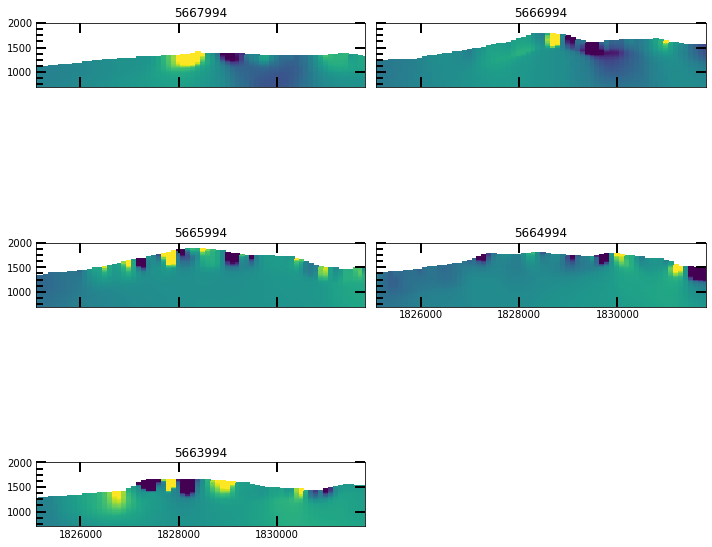

In [23]:
# plot section views
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5)) = plt.subplots(nrows=3, ncols=2, figsize = (10, 10))

fig.delaxes(ax5)

fig.subplots_adjust(wspace=0, hspace=0)
axs = [ax0, ax1, ax2, ax3, ax4, ax5]
layers = [5667994, 5666994, 5665994, 5664994, 5663994]

stream_color = 'k'
clim = (-0.00005, 0.00005)
for i_layer, ax in enumerate(axs[:-1]):
    jamp_lp_core[~actind_core] = np.nan
    indy = int(np.argmin(abs(mesh_core.vectorCCy-layers[i_layer])))
    cbar = mesh_core.plotSlice(jamp_lp_core, ind=indy, normal='Y', clim=clim, ax=ax)

    minorLocator = AutoMinorLocator(4)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)

    ax.tick_params(which='both', width=2, direction='in')
    ax.tick_params(which='major', length=10, direction='in', top= True, right=True)
    ax.tick_params(which='minor', length=7, direction='in', top = True)
    
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_ylim(700, 2000)
    ax.set_xlim(1825094, 1831794)    
    ax.set_title(("%.0f")%(layers[i_layer]))
    ax.set_xticks([1826000, 1828000, 1830000])
    ax.set_yticks([1000, 1500, 2000])
      
    if ~np.logical_or(i_layer==4,i_layer==3) :
        ax.set_xticklabels([])
    if np.logical_or(i_layer==1,i_layer==3):
        ax.set_yticklabels({})

plt.tight_layout()
plt.show()



In [24]:
# Write core of the L2 model to file in spherical formulation
mesh_core.writeUBC('mesh_core.msh')

jamp_lp_core[~actind_core] = -100
mesh_core.writeModelUBC('Tongairo_C_Lp_amp_core.mod', jamp_lp_core)